# **Meerkat Call Classifier**

This code takes in examples of calls of different types, trains a conv net model to detect which type, then can run this on new data.

In [2]:
from meerkat_call_detector_library import *
import os
import re

#params
train_classif_model = True
test_classif_model = False
batch_size=10
clips_dir  = '/home/arianasp/meerkat_detector/clips' #'/home/arianasp/meerkat_detector/clips' only has clips from ari labeled files
call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth']
verbose = True
model_dir = '/home/arianasp/meerkat_detector/models'
classif_model_name = 'classifier_7types_20epochs.h5'
epochs = 20
steps_per_epoch = 10000
max_size = 512

#test files
test_wav = '/home/arianasp/meerkat_detector/data/full_recordings/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.wav'
test_csv = '/home/arianasp/meerkat_detector/ground_truth/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.csv'

#PARAMS (don't change probably)
pad_len = 127
samprate = 8000
win_len = 4096

ground_truth_dir = '/home/arianasp/meerkat_detector/ground_truth'
wav_dir = '/home/arianasp/meerkat_detector/data/full_recordings'


#MAIN

#----------TRAIN OR LOAD MODEL -----------------------
if(train_classif_model):
    
    model = classifier_model(n_classes=10)


    # use categorical_crossentropy loss if your training data are one-hot encoded vectors
    # and use sparse_categorical_crossentropy loss if your training data
    # are integers indicating the class label (Keras one-hot encodes this internally for training)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['sparse_categorical_accuracy']) # same applies for sparse_categorical_accuracy



        
    #fit model
    model.fit_generator(data_generator_for_classif(clips_dir = clips_dir,batch_size = batch_size), epochs=epochs, use_multiprocessing=True, workers=16, steps_per_epoch=steps_per_epoch)

    #Save fitted model
    print('Saving model as: ' + classif_model_name)
    model.save(filepath=model_dir + '/' + classif_model_name) 

else:
    model = load_model(model_dir + '/' + classif_model_name)
    
# ------------- TEST MODEL -----------------------------

if(test_classif_model):
    files = os.listdir(ground_truth_dir)
    test_csvs = [file for file in files if not(re.search('_label.csv',file) or re.search('_label.CSV',file) or re.search('SOUNDFOC',file))]
    basenames = [os.path.splitext(file)[0] for file in test_csvs]
    test_wavs = [file + '.wav' for file in basenames]

    Xall = np.empty([0,512,128,1])
    yall = np.empty([0],dtype='int')
    print('generating data for ' + str(len(test_csvs)) + ' files')
    for i in range(len(test_csvs)):
        test_csv = test_csvs[i]
        test_wav = os.path.splitext(test_csv)[0] + '.wav'
        test_csv = ground_truth_dir + '/' + test_csvs[i]
        wav_path = wav_dir + '/' + test_wav

        print(i)
        print(test_csv)
        print(wav_path)

        if(os.path.exists(wav_path)):
            labels = read_labels_for_classif(test_csv)
            X, y = generate_test_data_for_classif(labels,wav_path)
            Xall = np.append(Xall,X,axis=0)
            yall = np.append(yall,y,axis=0)
        else:
            print('file not found: ' + wav_path)

    confusion = evaluate_classif(model,Xall,yall,call_types)

    plot_confusion_matrix(confusion,call_types)

Epoch 1/20


/home/arianasp/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


10000/10000 [==============================] - 120s 12ms/step - loss: 1.2232 - sparse_categorical_accuracy: 0.5041
Epoch 2/20
10000/10000 [==============================] - 118s 12ms/step - loss: 1.0159 - sparse_categorical_accuracy: 0.5920
Epoch 3/20
10000/10000 [==============================] - 118s 12ms/step - loss: 0.9445 - sparse_categorical_accuracy: 0.6285
Epoch 4/20
10000/10000 [==============================] - 119s 12ms/step - loss: 0.8476 - sparse_categorical_accuracy: 0.6640
Epoch 5/20
10000/10000 [==============================] - 119s 12ms/step - loss: 0.8258 - sparse_categorical_accuracy: 0.6750
Epoch 6/20
10000/10000 [==============================] - 119s 12ms/step - loss: 0.8155 - sparse_categorical_accuracy: 0.6821
Epoch 7/20
10000/10000 [==============================] - 119s 12ms/step - loss: 0.7854 - sparse_categorical_accuracy: 0.6972
Epoch 8/20
10000/10000 [==============================] - 119s 12ms/step - loss: 0.7792 - sparse_categorical_accuracy: 0.6961
Epo

TypeError: evaluate_classif() got an unexpected keyword argument 'normalize_by_reals'

/home/arianasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


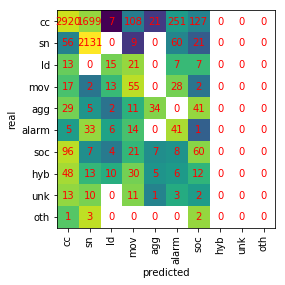

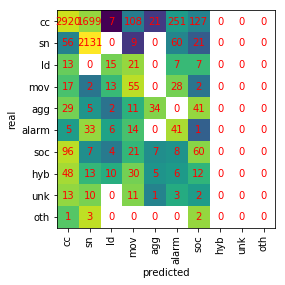

In [5]:
from sklearn.preprocessing import normalize

def plot_confusion_matrix(confusion,call_types,logscale=True,normalize_by_reals = True, normalize_by_preds = False):
    fig = plt.figure()
    plt.xticks(np.arange(start=0,stop=len(call_types)),call_types,rotation='vertical')
    plt.yticks(np.arange(start=0,stop=len(call_types)),call_types)
    plt.ylabel('real')
    plt.xlabel('predicted')
    to_plot = confusion
    if(normalize_by_reals):
        to_plot = normalize(confusion,axis=1,norm='l1')
    elif(normalize_by_preds):
        to_plot = normalize(confusion,axis=0,norm='l1')
    if(logscale):
        plt.imshow(np.log(to_plot))
    else:
        plt.imshow(to_plot)
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            plt.annotate(text = str(int(confusion[i,j])), xy=(j, i), ha='center',va='center',color='red')
    return(fig)

confusion = evaluate_classif(model,Xall,yall,call_types)

plot_confusion_matrix(confusion,call_types,normalize_by_reals=True,normalize_by_preds=False)

In [4]:
confusion = evaluate_classif(model,Xall,yall,call_types,normalize_by_reals=True,normalize_by_preds=False)

plot_confusion_matrix(confusion,call_types)


TypeError: evaluate_classif() got an unexpected keyword argument 'normalize_by_reals'

In [ ]:
#Take a look at the mistakes
out = model.predict(Xall)
preds = np.zeros(out.shape[0],dtype='int')
for i in range(out.shape[0]):
    preds[i] = int(np.argmax(out[i,:]))
    
matches = np.where(preds == yall)[0]
mismatches = np.where((preds != yall))[0]

In [ ]:
#Make plots of the mistakes

for i in range(len(mismatches)):
    idx = mismatches[i]

    X0 = Xall[idx,:,:,0]
    pred = call_types[preds[idx]]
    real = call_types[yall[idx]]

    plt.imshow(X0.T,aspect='auto',origin='lower')
    plt.title('Predicted: ' + pred + ' / Real: ' + real)
    print('Predicted: ' + pred)
    print('Real: ' + real)
    plt.savefig('/home/arianasp/meerkat_detector/figures/classif_mistakes/mistake' + str(idx) + '_pred_' + pred + '_real_' + real + '.pdf')
    


In [ ]:
print(Xall.shape)
print(yall.shape)
print(preds.shape)